In [47]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as ss
import biom
import qiime2
import pandas as pd
import numpy as np
import skbio
from qiime2.plugins import sample_classifier
from qiime2.plugins import diversity

In [22]:
md = pd.read_csv('pths_study_specific_metadata.tsv', sep='\t', dtype=str).set_index('#SampleID')

In [23]:
# filter to only samples used in ms analyses
sg = biom.load_table('Pitt_Hopkins_shotgun_shogun_gotu.biom')
ms = biom.load_table('Pitt_Hopkins_metabolomics_feature_table_min3samples_used_by_songbird.biom')
sg.filter(set(ms.ids()) & set(sg.ids())).remove_empty().norm()
md = md.loc[set(sg.ids())]

In [24]:
# G000371705	k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Lachnospiraceae;g__Lachnoclostridium;s__[Clostridium] bolteae;t__
# G000431175	k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Clostridiaceae;g__Clostridium;s__Clostridium bolteae CAG:59;t__
num = ['G000371705', 
       'G000431175'] 

# observed in all samples
# G000436995	k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Ruminococcaceae;g__Ruminococcus;s__Ruminococcus obeum CAG:39;t__
den = ['G000436995']

In [25]:
def get_lr(tab, num, den):
    tab_subset = tab.filter(set(num) | set(den), axis='observation', inplace=False).remove_empty()
    tab_num = tab_subset.filter(set(num), axis='observation', inplace=False).sum('sample')
    tab_den = tab_subset.filter(set(den), axis='observation', inplace=False).sum('sample')

    nnz = np.logical_and(tab_num != 0, tab_den != 0)
    tab_num = tab_num[nnz]
    tab_den = tab_den[nnz]

    lr = pd.Series(np.log(tab_num / tab_den), index=tab_subset.ids()[nnz])

    md['lr'] = lr
    md_subset = md.loc[lr.index]

    return md_subset

In [26]:
md_subset = get_lr(sg, num, den)

In [1]:
md_subset.head()
md_subset['age_years'] = pd.to_numeric(md_subset['age_years'], errors='coerce')
md_subset = md_subset[~md_subset['age_years'].isnull()]
md_subset = md_subset[(md_subset['pths_status'] == 'is_not_affected') | \
                      (md_subset['pths_status'] == 'is_affected')] #& (md_subset['age_years'] < 20))]

NameError: name 'md_subset' is not defined

[Text(0, 0, 'Parents'), Text(0, 0, 'PTHS')]

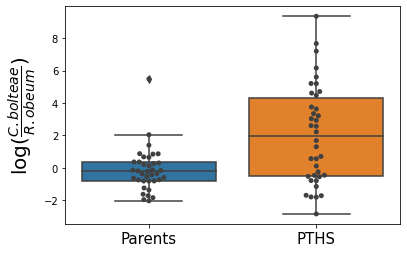

In [28]:
sns.boxplot(data=md_subset, x='pths_status', y='lr')
sns.swarmplot(data=md_subset, x='pths_status', y='lr', color=".25")
ax = plt.gca()
ax.set_ylabel(r'$\log (\frac{C. bolteae}{R. obeum})$', fontsize=20)
ax.set_xlabel("")
ax.set_xticklabels(['Parents', 'PTHS'], fontsize=15)
#plt.savefig('pths_status_cbolteae.pdf')

(-0.3545655092911254, 0.02894841788619535)
(-0.2675062172380009, 0.10945371596206618)


Text(0.5, 0, 'Age (years)')

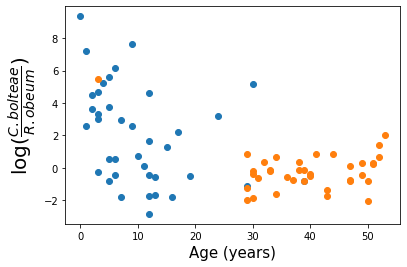

In [29]:
affected = md_subset[md_subset['pths_status'] == 'is_affected'].copy()
affected.sort_values('age_years', inplace=True)
#affected = affected[affected['age_years'] < 20]

unaffected = md_subset[md_subset['pths_status'] == 'is_not_affected'].copy()
unaffected.sort_values('age_years', inplace=True)
#unaffected = unaffected[affected['age_years'] < 20]

plt.scatter(affected['age_years'], affected['lr'])
plt.scatter(unaffected['age_years'], unaffected['lr'])

print(ss.pearsonr(affected['age_years'], affected['lr']))
print(ss.pearsonr(unaffected['age_years'], unaffected['lr']))

ax = plt.gca()
ax.set_ylabel(r'$\log (\frac{C. bolteae}{R. obeum})$', fontsize=20)
ax.set_xlabel('Age (years)', fontsize=15)
#plt.savefig('cbolteae-all-samples.pdf')

(-0.5428615731737604, 0.000909128543604334)


Text(0.5, 0, 'Age (years)')

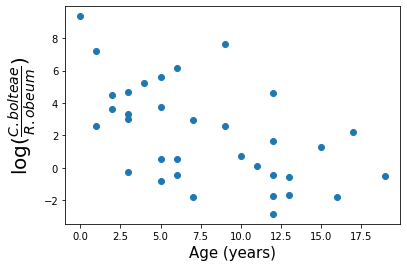

In [30]:
affected = md_subset[md_subset['pths_status'] == 'is_affected'].copy()
affected.sort_values('age_years', inplace=True)
affected = affected[affected['age_years'] < 20]
plt.scatter(affected['age_years'], affected['lr'])
print(ss.pearsonr(affected['age_years'], affected['lr']))
ax = plt.gca()
ax.set_ylabel(r'$\log (\frac{C. bolteae}{R. obeum})$', fontsize=20)
ax.set_xlabel('Age (years)', fontsize=15)

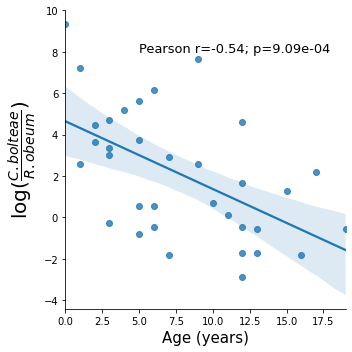

In [31]:
sns.lmplot(data=affected, x='age_years', y='lr')
r, p = ss.pearsonr(affected['age_years'], affected['lr'])
ax = plt.gca()
ax.set_ylabel(r'$\log (\frac{C. bolteae}{R. obeum})$', fontsize=20)
ax.set_xlabel('Age (years)', fontsize=15)
ax.text(5, 8, 'Pearson r=%0.2f; p=%0.2e' % (r, p), fontsize=13)
plt.tight_layout()
#plt.savefig('pths_scatter_cbolteae.pdf')


In [32]:
ss.ttest_ind(md_subset[md_subset.pths_status == 'is_affected']['lr'], 
             md_subset[md_subset.pths_status == 'is_not_affected']['lr'])

Ttest_indResult(statistic=3.999438411160202, pvalue=0.00015048384003331938)

In [33]:
ss.mannwhitneyu(md_subset[md_subset.pths_status == 'is_affected']['lr'], 
                md_subset[md_subset.pths_status == 'is_not_affected']['lr'])

MannwhitneyuResult(statistic=418.0, pvalue=0.0012853045192740237)

In [34]:
# bloom data from Amir et al (https://urldefense.com/v3/__https://github.com/knightlab-analyses/bloom-analyses/)*5Cn__;JQ!!LLK065n_VXAQ!3Qh12bBQZnwu1jRO1_N77r9RGx1zwyz56cHEsv4OSgTF-U5n_sj68XPhfmyEoj3D6Q$ blooms = blooms = {i.strip() for i in open('newbloom.all.fna') if not i.startswith('>')}

pths_16s = biom.load_table('Pitt_Hopkins_16s.biom')

# ag data obtained via redbiom as noted in methods
asd_16s = biom.load_table('june-2021-ag-16s/ag-fecal-asd.biom')
asd_16s_md = pd.read_csv('june-2021-ag-16s/ag-fecal-metadata-asd.txt', sep='\t', dtype=str).set_index('#SampleID')
noasd_16s = biom.load_table('june-2021-ag-16s/ag-fecal-no-asd.biom')
noasd_16s_md = pd.read_csv('june-2021-ag-16s/ag-fecal-metadata-no-asd.txt', sep='\t', dtype=str).set_index('#SampleID')

def filt(t, remove):
    t = t.filter(set(t.ids()) - set(remove), inplace=False)
    t = t.filter(set(t.ids(axis='observation')) - blooms, axis='observation', inplace=False).remove_empty()
    # remove samples with not many sequences
    return t.filter(lambda v, i, m: v.sum() > 1000, inplace=False).remove_empty()

# set remove pths unaffected
pths_16s = filt(pths_16s, set(pths_16s.ids()) - set(affected.index))

# make sure no pths samples are represented
asd_16s = filt(asd_16s, set(pths_16s.ids()))
noasd_16s = filt(noasd_16s, set(pths_16s.ids()))

pths_16s_focus = pths_16s.filter(set(affected.index), inplace=False).remove_empty()
asd_16s_md = asd_16s_md.loc[set(asd_16s.ids())]
noasd_16s_md = noasd_16s_md.loc[set(noasd_16s.ids())]

In [37]:
all_150nt_features = set(pths_16s_focus.ids(axis='observation')) | \
    set(asd_16s.ids(axis='observation')) | \
    set(noasd_16s.ids(axis='observation'))

In [39]:
#f = open('all_150nt_features.ids', 'w')
#f.write('\n'.join(all_150nt_features))
#f.write('\n')
# get SEPP feature placements out of band from Qiita (identical to qiime fragment-insertion)

In [40]:
import bp
tree = bp.parse_newick(open('asd-all_150nt_features.placements.tree').read())
tree = tree.shear(all_150nt_features).collapse()
tree = bp.to_skbio_treenode(tree)

In [41]:
len(all_150nt_features - {n.name for n in tree.tips()}) 

171

In [137]:
# note a random seed wasn't set so there is some minor variation in results below

def filt_to_tree_and_rare(t, tree):
    tips = {n.name for n in tree.tips()}
    t = t.filter(set(t.ids(axis='observation')) & tips, axis='observation', inplace=False).remove_empty()
    return t.subsample(1000)

pths_16s_rare = filt_to_tree_and_rare(pths_16s, tree)
asd_16s_rare = filt_to_tree_and_rare(asd_16s, tree)
noasd_16s_rare = filt_to_tree_and_rare(noasd_16s, tree)

pths_16s_focus = pths_16s_rare.filter(set(affected.index) & set(pths_16s_rare.ids()), inplace=False).remove_empty()
asd_16s_md = asd_16s_md.loc[set(asd_16s_rare.ids())]
noasd_16s_md = noasd_16s_md.loc[set(noasd_16s_rare.ids())]

In [138]:
tree_ar = qiime2.Artifact.import_data('Phylogeny[Rooted]', tree)
asd_ar = qiime2.Artifact.import_data('FeatureTable[Frequency]', asd_16s_rare)
noasd_ar = qiime2.Artifact.import_data('FeatureTable[Frequency]', noasd_16s_rare)
pths_16s_focus_ar = qiime2.Artifact.import_data('FeatureTable[Frequency]', pths_16s_focus)

In [139]:
asd_adiv, = diversity.actions.alpha_phylogenetic(table=asd_ar, phylogeny=tree_ar, metric='faith_pd')
noasd_adiv, = diversity.actions.alpha_phylogenetic(table=noasd_ar, phylogeny=tree_ar, metric='faith_pd')
pths_adiv, = diversity.actions.alpha_phylogenetic(table=pths_16s_focus_ar, phylogeny=tree_ar, metric='faith_pd')

In [140]:
asd_16s_md['faith_pd'] = asd_adiv.view(pd.Series)
noasd_16s_md['faith_pd'] = noasd_adiv.view(pd.Series)
affected['faith_pd'] = pths_adiv.view(pd.Series)

In [147]:
np.random.seed(1)

asd_16s_md['age_years'] = pd.to_numeric(asd_16s_md['age_years'])
asd_16s_md = asd_16s_md.loc[set(asd_16s_md.index) - set(affected.index)]  # remove same same
noasd_16s_md['age_years'] = pd.to_numeric(noasd_16s_md['age_years'])

def subsetter(md, val, offset):
    return md[(md['age_years'] < (val + offset)) & (md['age_years'] > (val - offset))]

results = []
used = set()
for pths, row in affected.iterrows():
    age = row['age_years']
    pths_pd = row['faith_pd']
    
    asd_subset = subsetter(asd_16s_md, age, 1)
    if len(asd_subset) == 0:
        print("no hits for %s" % pths)
        continue
    asd_dist = list(asd_subset['faith_pd'])
    
    noasd_subset = subsetter(noasd_16s_md, age, 1)
    if len(noasd_subset) == 0:
        print("no nonasd hits for %s" % pths)
        continue
    noasd_dist = list(noasd_subset['faith_pd'])
    
    results.append((pths, pths_pd, age, 'affected'))
    for v in asd_dist:
        if (v, age, 'AGP ASD') not in used:
            results.append((pths, v, age, 'AGP ASD'))
            used.add((v, age, 'AGP ASD'))
            
    for v in noasd_dist:
        if (v, age, 'AGP non-ASD') not in used:
            results.append((pths, v, age, 'AGP non-ASD'))
            used.add((v, age, 'AGP non-ASD'))
            
results = pd.DataFrame(results, columns=['PTHS', 'PD', 'age', 'group'])

In [148]:
results.shape

(1270, 4)

Text(0.5, 0, '')

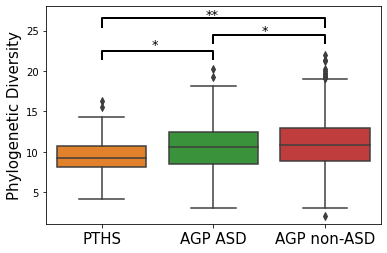

In [156]:
sns.boxplot(data=results, x='group', y='PD', palette=sns.color_palette()[1:])
ax = plt.gca()
ax.set_xticklabels(['PTHS', 'AGP ASD', 'AGP non-ASD'], fontsize=15)
ax.set_ylabel('Phylogenetic Diversity', fontsize=15)
ax.set_ylim(ax.get_ylim()[0], 28)
plt.plot([0, 0, 1, 1], [21.5, 22.5, 22.5, 21.5], linewidth=2, color='k')
ax.text(0.45, 22.8, '*', fontsize=13)
plt.plot([1, 1, 2, 2], [23.5, 24.5, 24.5, 23.5], linewidth=2, color='k')
ax.text(1.43, 24.6, '*', fontsize=13)
plt.plot([0, 0, 2, 2], [25.5, 26.5, 26.5, 25.5], linewidth=2, color='k')
ax.text(0.93, 26.6, '**', fontsize=13)
ax.set_xlabel("")
#plt.savefig("pths_pd_agp_asd.pdf")

In [157]:
ss.mannwhitneyu(results[results['group'] == 'affected']['PD'], results[results['group'] == 'AGP ASD']['PD'])

MannwhitneyuResult(statistic=3668.0, pvalue=0.013552873298254118)

In [158]:
ss.mannwhitneyu(results[results['group'] == 'affected']['PD'], results[results['group'] == 'AGP non-ASD']['PD'])

MannwhitneyuResult(statistic=11372.0, pvalue=0.0014845262026399408)

In [159]:
ss.mannwhitneyu(results[results['group'] == 'AGP ASD']['PD'], results[results['group'] == 'AGP non-ASD']['PD'])

MannwhitneyuResult(statistic=124957.0, pvalue=0.0398010159548003)

In [160]:
# based on an exact search of each fragment to G000371705 and G000431175,
# the following two ASVs recruited to G000371705 

#1 TACGTAGGGGGCAAGCGTTATCCGGATTTACTGGGTGTAAAGGGAGCGTAGACGGCGAAGCAAGTCTGAAGTGAAAACCCAGGGCTCAACCCTGGGACTGCTTTGGAAACTGTTTTGCTAGAGTGTCGGAGAGGTAAGTGGAATTCCTAG
#2 CAGCAGCCGCGGTAATACGTAGGGGGCAAGCGTTATCCGGATTTACTGGGTGTAAAGGGAGCGTAGACGGCGAAGCAAGTCTGAAGTGAAAACCCAGGGCTCAACCCTGGGACTGCTTTGGAAACTGTTTTGCTAGAGTGTCGGAGAGGT

# 1 and 2 are supported by BLAST hitting other non-genome bolteae records at 100%
# however there are some partial fragments coming from other clostridia so may not be exact species

In [161]:
bolteae_16s = [
    'TACGTAGGGGGCAAGCGTTATCCGGATTTACTGGGTGTAAAGGGAGCGTAGACGGCGAAGCAAGTCTGAAGTGAAAACCCAGGGCTCAACCCTGGGACTGCTTTGGAAACTGTTTTGCTAGAGTGTCGGAGAGGTAAGTGGAATTCCTAG',
    # 'CAGCAGCCGCGGTAATACGTAGGGGGCAAGCGTTATCCGGATTTACTGGGTGTAAAGGGAGCGTAGACGGCGAAGCAAGTCTGAAGTGAAAACCCAGGGCTCAACCCTGGGACTGCTTTGGAAACTGTTTTGCTAGAGTGTCGGAGAGGT'
]

# ...second one was not observed
pd.Series(pths_16s.filter(set(bolteae_16s), axis='observation', inplace=False).sum('sample') > 0).describe()

count       34
unique       2
top       True
freq        26
dtype: object

In [162]:
bolteae_16s = [
    'TACGTAGGGGGCAAGCGTTATCCGGATTTACTGGGTGTAAAGGGAGCGTAGACGGCGAAGCAAGTCTGAAGTGAAAACCCAGGGCTCAACCCTGGGACTGCTTTGGAAACTGTTTTGCTAGAGTGTCGGAGAGGTAAGTGGAATTCCTAG',
    # 'CAGCAGCCGCGGTAATACGTAGGGGGCAAGCGTTATCCGGATTTACTGGGTGTAAAGGGAGCGTAGACGGCGAAGCAAGTCTGAAGTGAAAACCCAGGGCTCAACCCTGGGACTGCTTTGGAAACTGTTTTGCTAGAGTGTCGGAGAGGT'
]

# ...second one was not observed
pd.Series(asd_16s.filter(set(bolteae_16s), axis='observation', inplace=False).sum('sample') > 0).describe()

count      315
unique       2
top       True
freq       167
dtype: object

In [163]:
bolteae_16s = [
    'TACGTAGGGGGCAAGCGTTATCCGGATTTACTGGGTGTAAAGGGAGCGTAGACGGCGAAGCAAGTCTGAAGTGAAAACCCAGGGCTCAACCCTGGGACTGCTTTGGAAACTGTTTTGCTAGAGTGTCGGAGAGGTAAGTGGAATTCCTAG',
    #'CAGCAGCCGCGGTAATACGTAGGGGGCAAGCGTTATCCGGATTTACTGGGTGTAAAGGGAGCGTAGACGGCGAAGCAAGTCTGAAGTGAAAACCCAGGGCTCAACCCTGGGACTGCTTTGGAAACTGTTTTGCTAGAGTGTCGGAGAGGT'
]

# ...second one was not observed
pd.Series(noasd_16s.filter(set(bolteae_16s), axis='observation', inplace=False).sum('sample') > 0).describe()

count      1047
unique        2
top       False
freq        554
dtype: object

In [164]:
#          pths asd non-asd 
# bolteae
# no bolteae
#
ct = pd.DataFrame(np.array([[26, 167, 1047-554], [34-26, 315-167, 554]]), 
                  columns=['PTHS', 'ASD', 'non-ASD'],
                  index=['C. bolteae', 'No C. bolteae'])

In [165]:
ct

,PTHS,ASD,non-ASD
C. bolteae,26,167,493
No C. bolteae,8,148,554


In [166]:
ss.fisher_exact(ct[['PTHS', 'ASD']])

(2.8802395209580838, 0.010454880580568194)

In [167]:
ss.fisher_exact(ct[['PTHS', 'non-ASD']])

(3.652129817444219, 0.0007603614273645063)

In [168]:
all_rare = pths_16s_focus.concat([asd_16s_rare.filter(set(asd_16s_rare.ids()) - set(pths_16s_focus.ids()), inplace=False), 
                                  noasd_16s_rare.filter(set(noasd_16s_rare.ids()) - set(pths_16s_focus.ids()), inplace=False)])
all_nonrare = pths_16s.concat([asd_16s.filter(set(asd_16s.ids()) - set(pths_16s.ids()), inplace=False), 
                               noasd_16s.filter(set(noasd_16s.ids()) - set(pths_16s.ids()), inplace=False)])

In [169]:
all_nonrare

54179 x 1396 <class 'biom.table.Table'> with 259843 nonzero entries (0% dense)

In [170]:
all_rare_features_ranked = pd.Series(all_rare.pa(inplace=False).sum('observation'), index=all_rare.ids(axis='observation')).sort_values(ascending=False)
all_nonrare_features_ranked = pd.Series(all_nonrare.pa(inplace=False).sum('observation'), index=all_nonrare.ids(axis='observation')).sort_values(ascending=False)

In [171]:
all_rare.filter(set(all_rare_features_ranked.head(5).index), axis='observation', inplace=False).remove_empty()
all_nonrare.filter(set(all_nonrare_features_ranked.head(5).index), axis='observation', inplace=False).remove_empty()

5 x 1390 <class 'biom.table.Table'> with 6197 nonzero entries (89% dense)

In [172]:
bolteae_asv_hits = pd.Series(all_nonrare.data('TACGTAGGGGGCAAGCGTTATCCGGATTTACTGGGTGTAAAGGGAGCGTAGACGGCGAAGCAAGTCTGAAGTGAAAACCCAGGGCTCAACCCTGGGACTGCTTTGGAAACTGTTTTGCTAGAGTGTCGGAGAGGTAAGTGGAATTCCTAG', axis='observation', dense=True), index=all_rare.ids())
denom = all_rare.filter(set(all_nonrare_features_ranked.head(5).index), axis='observation', inplace=False).remove_empty()
denom = pd.Series(denom.sum('sample'), index=denom.ids())
bolteae_asv_hits = bolteae_asv_hits.loc[denom.index]

In [173]:
bolteae_asv_hits

10317.000101389    35.0
10317.000101237     3.0
10317.000101213    11.0
10317.000101239     8.0
10317.000101291    15.0
                   ... 
10317.000107600     0.0
10317.000021819     0.0
10317.000097469     0.0
10317.000098794     0.0
10317.000112275     2.0
Length: 1382, dtype: float64

/Users/dtmcdonald/miniconda3/envs/qiime2-2020.8/lib/python3.6/site-packages/pandas/core/series.py:856: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/dtmcdonald/miniconda3/envs/qiime2-2020.8/lib/python3.6/site-packages/pandas/core/series.py:856: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/dtmcdonald/miniconda3/envs/qiime2-2020.8/lib/python3.6/site-packages/pandas/core/series.py:856: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


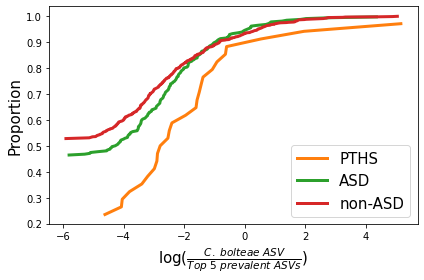

In [174]:
labels = []
colors = sns.color_palette()[1:]
for grp, l, c in [(pths_16s, 'PTHS', colors[0]), 
               (asd_16s, 'ASD', colors[1]), 
               (noasd_16s, 'non-ASD', colors[2])]:
    labels.append(l)
    grp_ids = set(bolteae_asv_hits.index) & set(grp.ids())
    x = np.sort(np.log(bolteae_asv_hits.loc[grp_ids] / denom.loc[grp_ids]))
    y = np.arange(len(x))/float(len(x))
    plt.plot(x, y, c=c, lw=3)
plt.legend(labels, fontsize=15)
ax = plt.gca()
ax.set_ylabel('Proportion', fontsize=15)
ax.set_xlabel(r'$\log (\frac{C.\ bolteae\ ASV}{Top\ 5\ prevalent\ ASVs})$', fontsize=15)
plt.tight_layout()
#plt.savefig('pths_ecdf_bolteae_asv.pdf')